# Images with $n$ channels in fastai

In this notebook, we'll look at how to adapt a neural network pre-trained on regular images of 3 channels (RGB images) to work on images with $n > 3$ channels, such as satellite pictures or other pictures produced from specialized sources. We will do this by changing the number of inputs for the first layer of the convoluional network from 3 to $n$. We will use ResNet as an example, but the method here should work with minor modifications for most types of CNNs, because it works by modifying only the first layer.

The implementation is heavily based on the work of GitHub user artste in [this notebook](https://github.com/artste/fastai-samples/blob/master/kaggle/lesson2-protein-human-protein-atlas-384-resnet50_data_block.ipynb). His method, however, only works for 4-channel images because it relies on `fastai.vision.Image`. Here, we extend it to $n$-channels by implementing a custom `ItemBase` subclass. The previous method was developed in the context of the Human Protein Atlas Kaggle competition. Here, here we solve a toy problem to really focus on the $n$-channel implementation and not worry about interpreting a real application.

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

from pathlib import Path
from itertools import cycle
from tempfile import TemporaryDirectory
from uuid import uuid4

import torch
import fastai.core as fc
import fastai.vision as fv
from fastai.basic_data import DatasetType

## Generate data

We are going to be solving a toy problem with an imaginary dataset. All files will be kept in a temporary folder and will be automatically deleted when the notebook closes.

In [2]:
data_directory = TemporaryDirectory()
data_path = Path(data_directory.name)
(data_path / 'images').mkdir() # Create an images subfolder
print(f"Temporary directory for the data: {data_path}")

Temporary directory for the data: /var/folders/9x/ql9hp5nn7sl402bfp3cq1wgr0000gn/T/tmpk71xjg2h


Our data will be images of size 64x64 and 7 channels. We will be predicting two imaginary labels: `high` and `low`. Each pixel value is taken from a normal distribution with mean zero and variance one. For images in the `high` class, however, the pixels in the 6th channel are taken from a normal distribution with mean 3 and variance 1. The point of the notebook is not to solve this easy problem, but to showcase the $n$-channel image framework in fastai.

We save the images as `.npy` files of shape 64 x 64 x 7. We create $N = 1000$ images total, with half being in the `high` class and half in the `low` class.

In [3]:
N = 1000 # How many images in the data set, total?
assert N % 2 == 0 # Let's make it an even number of images

In [4]:
# Unique identifiers for each image
identifiers = [uuid4() for _ in range(N)]

In [5]:
# Generate the labels
labels = ['high' for _ in range(N//2)] + ['low' for _ in range(N//2)]

Now we create a DataFrame with the data. This is the same table that will later be passed to the fastai library to create our `ItemList`.

In [6]:
df = pd.DataFrame({'uid': identifiers,
                   'label': labels})
# Take a look at the result
df.sample(10)

,uid,label
676,84cde4db-e2f8-43d2-bbb2-09ba010c0f98,low
140,c313282a-7463-4064-894b-f46b9bd50b1f,high
836,6af02328-1fab-4669-a8a0-34fcfbe675cb,low
487,bb2c742b-67ec-474a-b4b0-1d54c1b0957d,high
321,83519483-561d-45ea-b989-8cd60a28a0eb,high
872,d0fecc38-ef6d-4f43-92c7-1f058bae3dde,low
584,a7eae09e-e725-4f27-b093-df61e276ef8b,low
17,ae1c6f23-1150-4a84-a0ef-4993102df5fc,high
591,85b03caa-6cd2-432b-a1e6-62de7564c69f,low
549,e5120f88-f19b-49bf-9963-a298c02e5999,low


Now let's generate the data itself.

In [7]:
IMG_SIZE = 64
NUM_CHANNELS = 7

for ix, datapoint in df.iterrows():
    name = datapoint['uid']
    label = datapoint['label']
    image = np.random.normal(loc=0, scale=1, size=(IMG_SIZE, IMG_SIZE, NUM_CHANNELS))
    if label == 'high':
        # If image is "high", values in its 6th channel are higher
        image[:, :, 5] = np.random.normal(loc=3, scale=1, size=(IMG_SIZE, IMG_SIZE))
    # Save image as .npy in our temporary directory
    np.save(data_path / 'images' / (str(name) + '.npy'), image)

## Implement $n$-channel images in fastai

Now that we've created our toy data we can move on to the implementation of $n$-channel images in fastai. We can't use `fastai.vision.Image`, as that class is hardcoded to only accept data with 3 or 4 channels. Instead, we will create a custom `ItemBase`.

The chief piece of code to customize if you want to use this is the function `img_to_tensor`. The function should open a file with your image and convert it to a tensor of shape $n \times H \times W$, where $n$ is the number of channels. In our case, we customize the function so it opens our `.npy` files and changes the order of the channels, since the images were saved with shape $H \times W \times n$.

In [8]:
def img_to_tensor(filename):
    """Open an n-channel image.
    
    Args:
        filename: String with the filename.
        
    Returns:
        A PyTorch tensor of shape nxHxW.
    """
    array = np.load(filename).transpose([2, 0, 1])
    tensor = torch.Tensor(array)
    return tensor

Now, we implement a custom `ItemBase` to represent single $n$-channel images. We also create a custom `ItemList` to hold a bunch of our $n$-channel images.

**Note:** The way I have implemented image transformations, each transformation is applied separately for each channel. This *might* create non-interpretable situations downstream, depending on how transforms are coded. If in doubt, avoid doing transformations to $n$-channel images.

In [9]:
class NChannelImage(fc.ItemBase):
    
    def __init__(self, data):
        """Create a n-channel image.
        
        Args:
            data: A Pytorch tensor of shape n_channels x height x width.
        """
        self.data = data
        self.obj = data
        self.size = tuple(data.shape[1:])
        
    def apply_tfms(self, transforms, do_resolve=True, **kwargs):
        """Apply transformations for data augmentation.
        The way this is implemented now, we apply the transformations separately
        for each of the n channels.
        """
        transformed = []
        # We want use the same transform to each channel,
        # so we resolve their random parameters now.
        if do_resolve:
            fv.image._resolve_tfms(transforms)
        for i, channel in enumerate(self.data):
            im = fv.Image(channel.unsqueeze(0))
            im = im.apply_tfms(transforms, do_resolve=False, **kwargs)
            transformed.append(im.data.squeeze())
        # The reason we stack is to allow for outputs of the transformation to
        # be a different size than the inputs.
        transformed = torch.stack(transformed, dim=0)
        return NChannelImage(transformed)
    
    def show(self, ax, channels=None, **kwargs):
        """Shows selected channels of image on plot."""
        if channels is None:
            channels = [0, 1, 2]
        assert len(channels) in [1, 3], "Channels should be a list of length 1 or 3."
        reduced_img = fv.Image(self.data[channels].clone())
        return reduced_img.show(ax, **kwargs)
    
    def __str__(self):
        n, h, w = tuple(self.data.shape)
        return f"{n}x{h}x{w}"
    
    
class NChannelImageList(fv.ImageItemList):
    
    def open(self, filename):
        tensor = img_to_tensor(filename)
        return NChannelImage(tensor)
    
    def reconstruct(self, tensor):
        return NChannelImage(tensor.clamp(min=0,max=1))

Now, we can safely create a `NChannelImageList` from our previous DataFrame and our temporary folder of data. That feeds directly into the data block API of the fastai library.

In [10]:
datalist = NChannelImageList.from_df(df, path=data_path, cols='uid', folder='images', suffix='.npy')
datalist

NChannelImageList (1000 items)
[NChannelImage 7x64x64, NChannelImage 7x64x64, NChannelImage 7x64x64, NChannelImage 7x64x64, NChannelImage 7x64x64]...
Path: /var/folders/9x/ql9hp5nn7sl402bfp3cq1wgr0000gn/T/tmpk71xjg2h

In [11]:
labeled = (datalist
           .random_split_by_pct(valid_pct=0.2, seed=42)
           .label_from_df(cols='label'))

We can apply transformations to the data as well.

In [12]:
transforms = fv.get_transforms(do_flip=True, flip_vert=False)
transformed = (labeled
               .transform(transforms, size=32))

Finally we convert everything into a `DataBunch`.

In [13]:
data = transformed.databunch(bs=64)
data

ImageDataBunch;

Train: LabelList
y: CategoryList (800 items)
[Category high, Category high, Category high, Category high, Category high]...
Path: /var/folders/9x/ql9hp5nn7sl402bfp3cq1wgr0000gn/T/tmpk71xjg2h
x: NChannelImageList (800 items)
[NChannelImage 7x64x64, NChannelImage 7x64x64, NChannelImage 7x64x64, NChannelImage 7x64x64, NChannelImage 7x64x64]...
Path: /var/folders/9x/ql9hp5nn7sl402bfp3cq1wgr0000gn/T/tmpk71xjg2h;

Valid: LabelList
y: CategoryList (200 items)
[Category low, Category low, Category low, Category low, Category high]...
Path: /var/folders/9x/ql9hp5nn7sl402bfp3cq1wgr0000gn/T/tmpk71xjg2h
x: NChannelImageList (200 items)
[NChannelImage 7x64x64, NChannelImage 7x64x64, NChannelImage 7x64x64, NChannelImage 7x64x64, NChannelImage 7x64x64]...
Path: /var/folders/9x/ql9hp5nn7sl402bfp3cq1wgr0000gn/T/tmpk71xjg2h;

Test: None

In [14]:
data.classes

['high', 'low']

In [15]:
for i in data.train_ds[:10]:
    print(i)

(NChannelImage 7x32x32, Category high)
(NChannelImage 7x32x32, Category high)
(NChannelImage 7x32x32, Category high)
(NChannelImage 7x32x32, Category high)
(NChannelImage 7x32x32, Category high)
(NChannelImage 7x32x32, Category high)
(NChannelImage 7x32x32, Category high)
(NChannelImage 7x32x32, Category high)
(NChannelImage 7x32x32, Category high)
(NChannelImage 7x32x32, Category high)


We can also visualize the $n$-channel images using the regular fastai methods. By default, we treat the first 3 channels of the image as RGB and ignore the others. These ones look ugly because the pixel values were generated randomly.

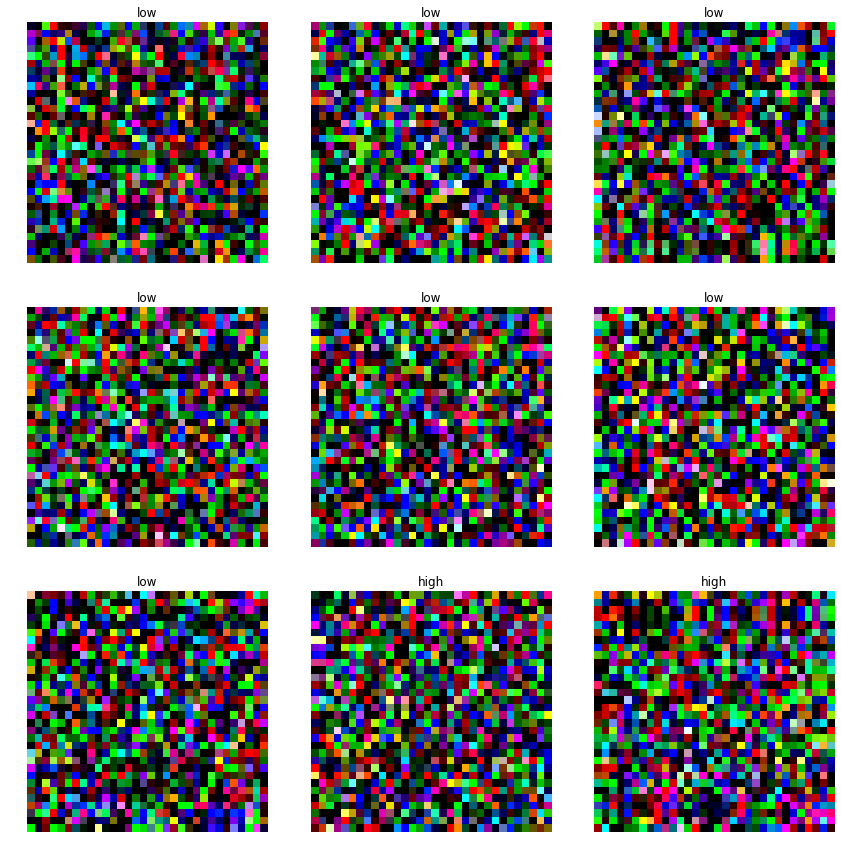

In [16]:
data.show_batch(rows=3)

But if we have $n$-channel images, we might want to look at some other combination of channels as the RGB values. We can pass the additional argument `channels` to `DataBunch.show_batch` to tell what channels to visualize. For instance, we can look at channels 6, 3, and 2 as the RGB values. This allows us to see channel 6, the one with all the signal to separate the data. You can see that images in the `high` class look more red.

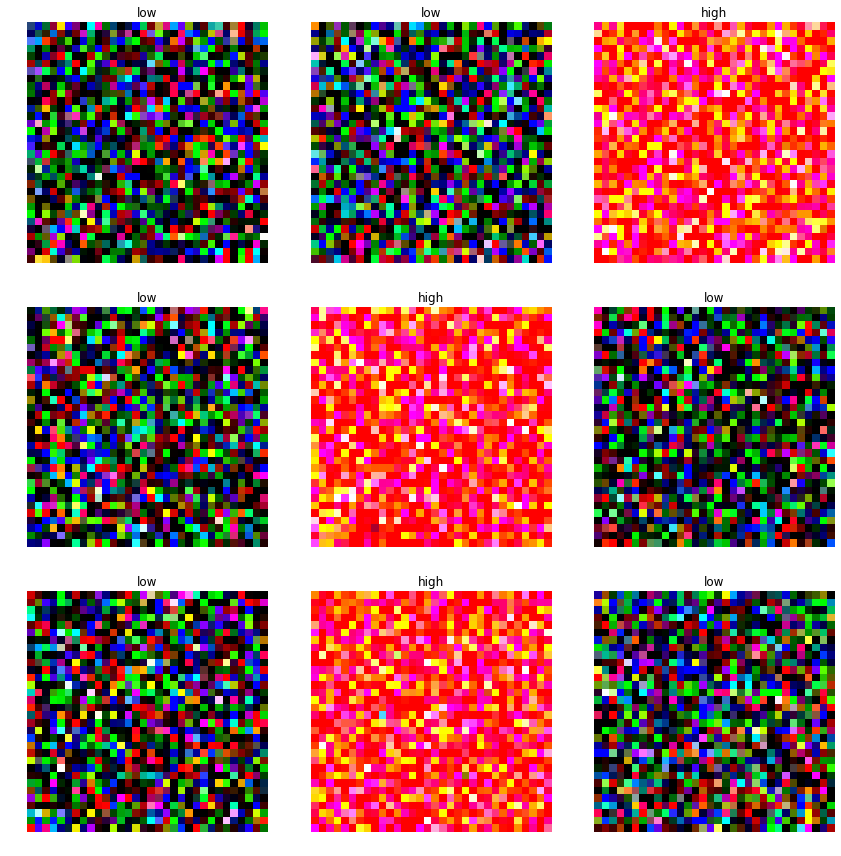

In [17]:
data.show_batch(rows=3, channels=[5, 2, 1])

We can also look at just the sixth channel, on its own.

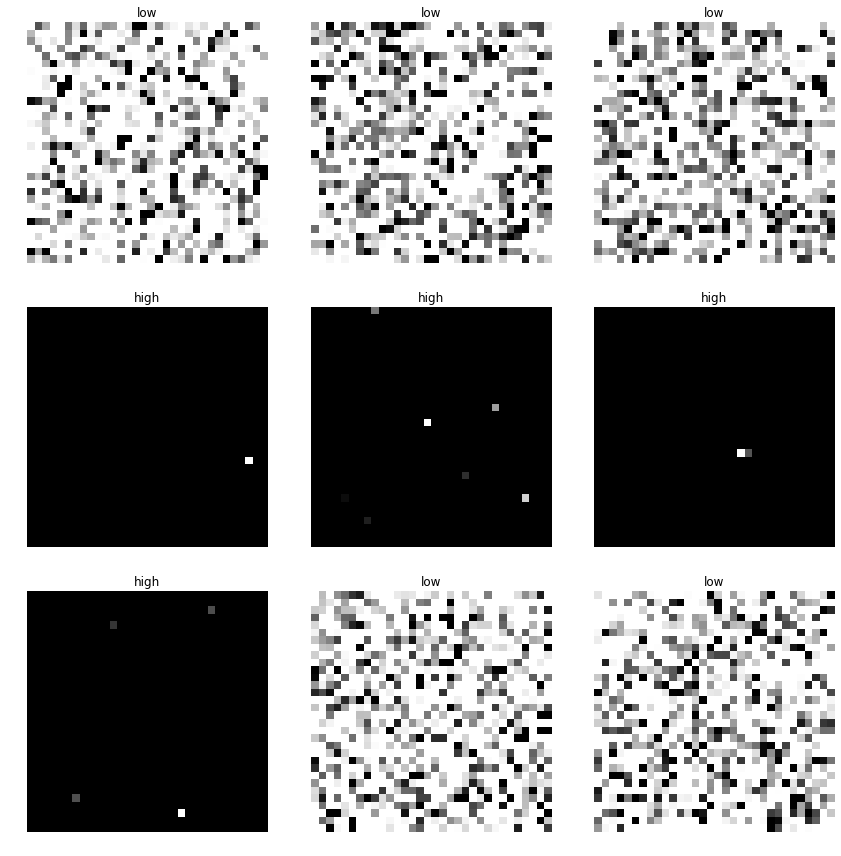

In [18]:
data.show_batch(rows=3, channels=[5], cmap='binary')

## Adapt neural network

Adapting the neural network happens in two steps:

1. We change the number of inputs for the first convolutional layer: instead of taking in 3 channels, we take in $n$ channels.
2. We give weights to the new channels.

Step 2 can be customized in the function `adapt_weights`. Here, we will repeat the original weights from the 3 channel network like this:

    channel    original weights    new weights
          1            R                R
          2            G                G
          3            B                B
          4            -                R
          5            -                G
          6            -                B
          7            -                R
          ... and so on
          
This allows us to train the network in a frozen state, and those weights would still be *somewhat* reasonable. Other options include setting all weights to zeros or random values, but those would be less useful for transfer learning with a frozen network.

In [19]:
def adapt_weights(old_weights, new_weights):
    """Adapts weights of the neural network by cycling through the old channel weights.
    
    Args:
        old_weights: The PyTorch tensor with the weight vector of the non-adapted first layer.
        new_weights: The PyTorch tensor with the weight vector of the first layer adapted to n channels.
        
    Returns:
        A PyTorch tensor of the same shape as new_weights, with the desired initial weights.
    """
    num_channels = new_weights.shape[1]
    cycler = cycle([0, 1, 2])
    for i in range(num_channels):
        original_weight_ix = next(cycler)
        new_weights[:, i, :, :] = old_weights[:, original_weight_ix, :, :]
    return new_weights

def adapt_cnn(cnn, num_channels, gpu=True):
    """Modify a neural network to take in more channels as input.
    
    Args:
        cnn: A fastai Learner object.
        num_channels: How many channels do input images have?
        gpu: If True (default), put the resulting model in the GPU.
        
    Returns:
        Nothing. The Learner object if modified in-place.
    """
    first_layer = cnn.model[0][0]
    
    # Create new layer with right number of inputs
    new_layer = torch.nn.Conv2d(num_channels,
                                first_layer.out_channels,
                                kernel_size=first_layer.kernel_size,
                                stride=first_layer.stride,
                                padding=first_layer.padding,
                                bias=False)
    
    # Adapt weights vector
    old_weights = first_layer.weight.clone()
    new_weights = new_layer.weight.clone()
    new_weights = adapt_weights(old_weights, new_weights)
    new_layer.weight = torch.nn.Parameter(new_weights)
        
    cnn.model[0][0] = new_layer
    if gpu:
        cnn.model.cuda()
    # Return None to make it explicit that we change the model in-place.
    return None

In [20]:
cnn = fv.create_cnn(data, arch=fv.models.resnet34, metrics=fv.error_rate, pretrained=True)

# Save original weights so we can verify later.
original_weights = cnn.model[0][0].weight.clone()

In [21]:
# Pass gpu=True to if your machine has a GPU.
adapt_cnn(cnn, 7, gpu=False)

# Make sure it behaves as we expect
new_weights = cnn.model[0][0].weight.clone()
torch.equal(new_weights[:, 3, :, :], original_weights[:, 0, :, :])

True

## Train neural network

The weights for the extra channels in the first layer are not normally modified, just like when using regular "frozen" models in fastai. When we unfreeze the model, those weights can now change. This is an easy enough problem that it can be solved with a frozen network, but we start by unfreezing it to showcase that it works with $n$-channel images.

If you have a lot more than 3 channels, the extra number of weights that have to be fit might make fine-tuning the unfrozen model harder than expected.

In [22]:
cnn.unfreeze()

In [23]:
# The default learning rate is way too high for this problem
cnn.fit_one_cycle(3, max_lr=1e-4)

epoch,train_loss,valid_loss,error_rate
1,0.813521,0.652534,0.415000
2,0.606371,0.420579,0.295000
3,0.477041,0.219220,0.020000


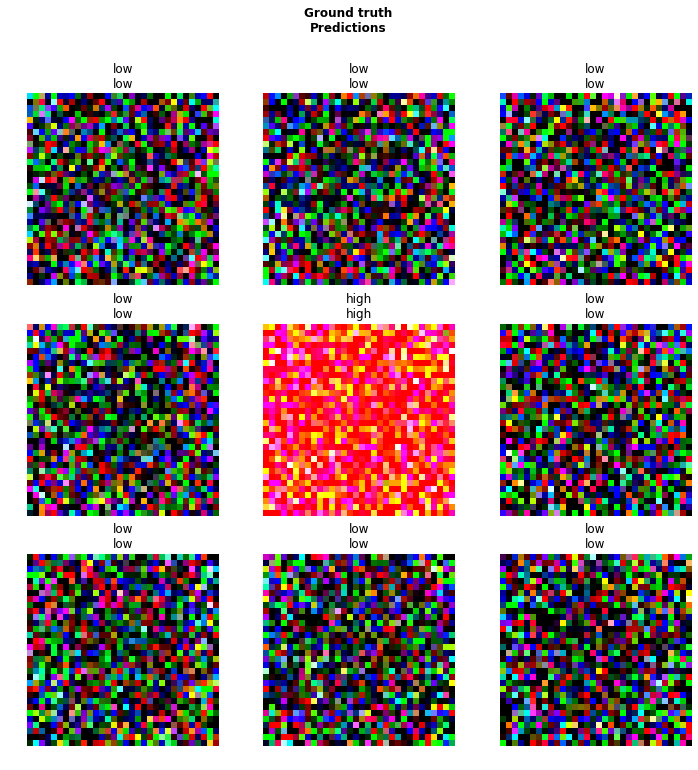

In [24]:
# The channels argument also works with `Learner.show_results`.
cnn.show_results(rows=3, channels=[5, 2, 1])

#### Interpreting classification

The standard `ClassificationInterpretation.plot_top_losses` function does not work with our $n$-channel images, because it does not support passing arguments to the custom `NChannelImage.show` method. Here's a new class that does:

In [25]:
class NChannelClassificationInterpretation(fv.ClassificationInterpretation):
    
    def __init__(self, data, probs, y_true, losses, ds_type=DatasetType.Valid):
        # This is identical to the parent class' __init__ method and is only copied here
        # because if we don't, for some reason, self.ds_type is never set.
        self.data = data
        self.probs = probs
        self.y_true = y_true
        self.losses= losses
        self.ds_type = ds_type
        self.pred_class = self.probs.argmax(dim=1)
    
    def plot_top_losses(self, k, largest=True, figsize=(12,12), **kwargs):
        # This is a copy-paste of the original function, with **kwargs added for n-channel image support.
        tl_val,tl_idx = self.top_losses(k,largest)
        classes = self.data.classes
        cols = math.ceil(math.sqrt(k))
        rows = math.ceil(k/cols)
        fig,axes = plt.subplots(rows,cols,figsize=figsize)
        fig.suptitle('prediction/actual/loss/probability', weight='bold', size=14)
        for i,idx in enumerate(tl_idx):
            im,cl = self.data.dl(self.ds_type).dataset[idx]
            cl = int(cl)
            im.show(ax=axes.flat[i],
                    title=f'{classes[self.pred_class[idx]]}/{classes[cl]} / {self.losses[idx]:.2f} / {self.probs[idx][cl]:.2f}',
                    **kwargs)

In [26]:
probabilities, true_classes, loss_values = cnn.get_preds(with_loss=True)
interpreter = NChannelClassificationInterpretation(data, probabilities, true_classes, loss_values)

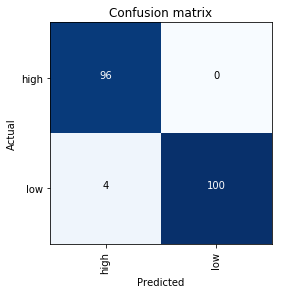

In [27]:
interpreter.plot_confusion_matrix()

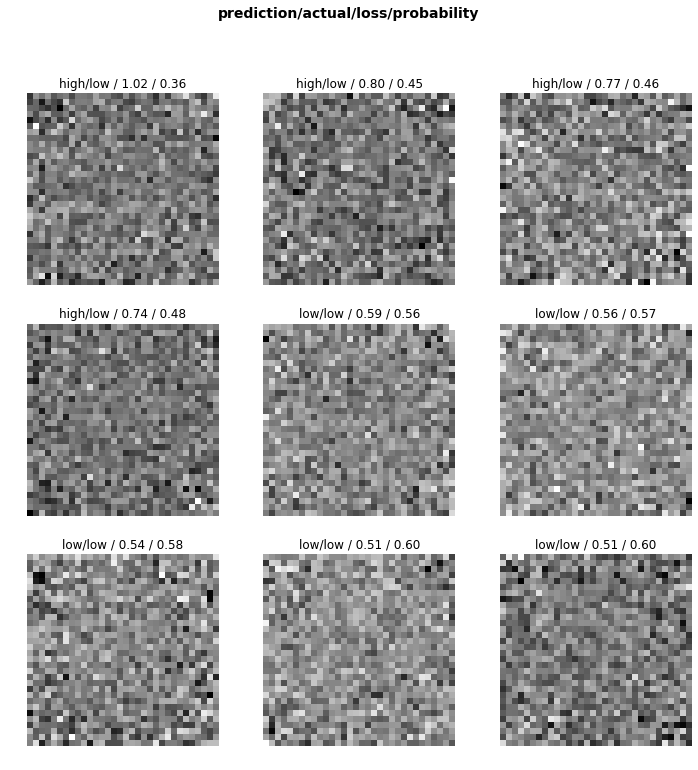

In [28]:
interpreter.plot_top_losses(9, channels=[5], cmap='binary')

The above plot makes it clear that the images that the network gets wrong are the "high" images that, by random chance, have a 6th channel that looks like the one in the "low" images.